In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

#importing helper functions for pre-processing data
from util import cleaning_data, stemming, wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oleksandrafilippova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# cleanine_data function loads in data, adds labels, removes all punctuation, digits & stop words 
data = cleaning_data("data/true.csv", "data/fake.csv", "title", False)

/Users/oleksandrafilippova/ML_class/final_project/nlp_project_yas/util.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = true_df.append(fake_df).sample(frac=1).reset_index().drop(columns=['index'])


Example of the dataset `data` consisting of both labels(1 is True, 0 is Fake):

In [3]:
data

,title,target
0,hillary eviscerates trump abortion comments ab...,0
1,liberal lunatic chris matthews scolded piers m...,0
2,pocahontas calls trump comments dem senator gi...,0
3,syrian militant group releases video leader ap...,1
4,house democrats stage sit get gun control bill...,1
...,...,...
44893,alec baldwin joins anti trump protest gives sp...,0
44894,kidding students given counseling seeing symbo...,0
44895,pga gave donald trump big middle finger p ssed,0
44896,video divider chief barack obama invokes word ...,0


In [5]:
print('distribution of word frequencies before stemming: ')
pd.Series(' '.join(data.title).split()).value_counts().describe()

distribution of word frequencies before stemming: 


count    20303.000000
mean        20.653598
std        143.011958
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max      14899.000000
dtype: float64

In [6]:
print('top 10 words before stemming are: ')
pd.Series(' '.join(data.title).split()).value_counts()[:10]

top 10 words before stemming are: 


trump      14899
video       8508
says        3542
obama       3247
hillary     2366
house       2001
watch       1966
u           1937
clinton     1794
new         1780
dtype: int64

In [7]:
print('top 10 words in true articles before stemming are: ')
pd.Series(' '.join(data[data.target == 0].title).split()).value_counts()[:10]

top 10 words in true articles before stemming are: 


trump        9338
video        8477
obama        2582
hillary      2319
watch        1937
president    1146
clinton      1138
new           905
breaking      896
black         896
dtype: int64

In [8]:
print('top 10 words in false articles before stemming are: ')
pd.Series(' '.join(data[data.target == 1].title).split()).value_counts()[:10]

top 10 words in false articles before stemming are: 


trump     5561
says      2981
u         1883
house     1449
russia     977
north      926
korea      898
new        875
white      818
china      782
dtype: int64

Cloud of words for the entire dataset:


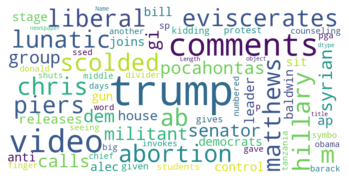

Cloud of words for false articles:


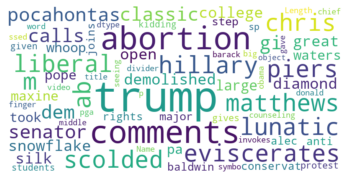

Cloud of words for true articles:


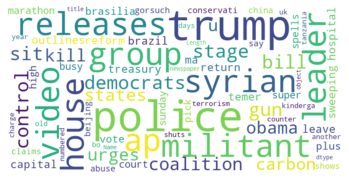

In [9]:
%matplotlib inline
print('Cloud of words for the entire dataset:')
wordcloud(data.title, 100)

print('Cloud of words for false articles:')
wordcloud(data[data.target == 0].title, 100)

print('Cloud of words for true articles:')
wordcloud(data[data.target == 1].title, 100)

## From the descriptive statistics above: 

- The dataset consists `20,303` unique words after stop words (i.e., *you*, *she*, *and*).
- The median frequency among all words equals to `3`. Meaning, at least a half of all words were mentioned once, twice or three times in the entire dataset.
- The word that was mentioned the most is `trump`. It was mentioned `14,899` times. 

Having `20,303` features for a `40,000`-observation dataset we are risking to encounter **Curse of Dimensionality**. We need to reduce the number of total features before training the model.

In [10]:
data['title'] = stemming(data['title'])

In [11]:
print('distribution of stems frequencies after stemming: ')
pd.Series(' '.join(data.title).split()).value_counts().describe()

distribution of stems frequencies after stemming: 


count    13101.000000
mean        32.007480
std        187.006322
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max      14924.000000
dtype: float64

In [12]:
print('top 10 stems after stemming are: ')
pd.Series(' '.join(data.title).split()).value_counts()[:10]

top 10 stems after stemming are: 


trump         14924
video          8598
say            4131
obama          3264
hillari        2366
hous           2059
watch          2019
u              1937
presid         1929
republican     1843
dtype: int64

## From the descriptive statistics above (after stemming): 

- The dataset consists `13,101` unique tokens (stems). By stemming we were able to eliminate 7,202 features (35%).
- The median frequency among all tokens equals to `4`.  
- Like in the distribution before stemming, the word that was mentioned the most is `trump`. It was mentioned `14,924` times. 

This is still a high number of potential features. We may need to reduce it more.

In [13]:
# Split the data into two parts: training data (7/10) and other data (3/10)
train_text, val_test_text = train_test_split(data, random_state=1234, test_size=0.3, stratify=data['target'])

# Split other data into two parts: validation data (1/3 * 3/10 = 1/10) and testing data (2/3 * 3/10 = 2/10)
val_text, test_text = train_test_split(val_test_text, random_state=1234, test_size=0.6, stratify=val_test_text['target'])

Example of the `train_text` data frame:

In [14]:
train_text

,title,target
22144,indian forc kill milit leader nephew kashmir p...,1
29588,great elector map prove trump would win elect ...,0
15902,still butthurt event trump refus invit corresp...,0
21168,southern african leader discuss zimbabw tuesday,1
12543,oust catalan presid say stand readi cooper bel...,1
...,...,...
10965,trump blame berni sander campaign violenc epic...,0
2888,laura ingraham brilliant idea shake liber coll...,0
40339,red cross say access islam state famili held n...,1
33605,daniel greenfield obama realli spi trump ideol...,0


For our baseline model, we will be using the `TF-IDF` Vectorizer to pre-process articles and then apply Logistic Classifier.

- **fit_transform()** method learns vocabulary and `IDF` used for both training & test data. Returns document-term matrix with calculated `TF-IDF` values.

- **transform()** method uses the vocabulary and document frequencies (df) learned by **fit_transform()**. Returns document-term matrix with calculated `TF-IDF` values.

In [15]:
# Note, ngrams = 1, which is the default value if not specified in TfidfVectorizer. 
text_transformer = TfidfVectorizer(stop_words='english', max_features=1000)

# vectorize train and test data. Produce TF-IDF for train data
X_train_text = text_transformer.fit_transform(train_text.title)
X_val_text = text_transformer.transform(val_text.title)
X_test_text = text_transformer.transform(test_text.title)

Below is the example of 100 features to be used in the model: 

In [16]:
feature_names = text_transformer.get_feature_names_out()
feature_names[:100]

array(['abort', 'absolut', 'abus', 'accept', 'access', 'account', 'accus',
       'act', 'action', 'activist', 'actor', 'actual', 'ad', 'address',
       'administr', 'admit', 'advis', 'afghan', 'afghanistan', 'africa',
       'african', 'agenc', 'agenda', 'agent', 'agre', 'ahead', 'aid',
       'aim', 'air', 'airport', 'al', 'alabama', 'alien', 'alleg', 'alli',
       'allow', 'ambassador', 'amend', 'america', 'american', 'amid',
       'anchor', 'angri', 'announc', 'anoth', 'answer', 'anthem', 'anti',
       'antifa', 'apolog', 'appeal', 'appear', 'appoint', 'approv',
       'arabia', 'arm', 'armi', 'arrest', 'asia', 'ask', 'assault',
       'attack', 'attempt', 'attend', 'attorney', 'audio', 'australia',
       'author', 'avoid', 'away', 'awesom', 'babi', 'bad', 'baltimor',
       'ban', 'bank', 'bannon', 'bar', 'barack', 'base', 'bash',
       'bathroom', 'battl', 'beat', 'becom', 'begin', 'believ', 'ben',
       'benghazi', 'berni', 'best', 'better', 'bid', 'biden', 'big',
       

In [17]:
print('The number of observations (articles) in  the train data: ', X_train_text.shape[0])
print('The number of features (tokens) in  the train data: ', X_train_text.shape[1])

The number of observations (articles) in  the train data:  31428
The number of features (tokens) in  the train data:  1000


Example of `TF-IDF` matrix, **val_text**, for the validation dataset:

In [18]:
X_val_text.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

We will be using the `Logistic Classifier` as our baseline model for training:

In [19]:
logit = LogisticRegression(penalty = 'l2', C = 1, solver= 'sag', multi_class = 'multinomial')
logit.fit(X_train_text, train_text['target'])

LogisticRegression(C=1, multi_class='multinomial', solver='sag')

Now that we have trained our model, we will apply it to predict labels (true/false) for articles in the test data and calculate the accuracy score:

In [20]:
train_predicted_label = logit.predict(X_train_text)
train_accuracy_score = accuracy_score(train_text['target'], train_predicted_label)

predicted_label = logit.predict(X_val_text)
accuracy_score = accuracy_score(val_text['target'], predicted_label)

print('the accuracy score on the training data is: ', train_accuracy_score)
print('the accuracy score on the validation data is: ', accuracy_score)

the accuracy score on the training data is:  0.9287577955962836
the accuracy score on the validation data is:  0.9194506310319228


**Future steps:**

- Continue cleaning data with the use of Regex and other packages (digits, punctation, 'Router', '21st century')

- Further analysis of data

- Re-run model after data is cleaned

- Discover options to improve the model

Notes form meeting with Cole:

try different models with different # number of features 

1. spacy for steming/punctation - `done`
2. remove article sources - `done`
3. try different # of features - `pending`

analysis: size of trainings 
distribution of words 